<a href="https://colab.research.google.com/github/Kemquiros/fuzzy-kohonen-clustering-network/blob/master/Fuzzy_Kohonen_Clustering_Network_compartir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kohonen Clustering Network
Es una heurística, su convergencia no depende de optimizar un modelo o de los datos.

El vector final de pesos depende del orden de los datos de entrada
Los parametros: tasa de aprendizaje y el tamaño de actualización de la vecindad y la estrategia para cambiar estos parametros durante el entrenameinto deben variar de un conjunto de datos a otro para tener resultados efectivos.


# Leyes Clásicas de Asociación
Entidades mentales (ideas, sensaciones, sentimientos) se encuentran asociadas si cumplen las siguientes características:

1.   Si ocurren de forma simultanea (contacto espacial)
2.   Si ocurren de forma consecutiva (contacto temporal)
3.   Si son similares
4.   Si son opuestos

In [41]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import datasets
from sklearn import preprocessing
from sklearn.metrics import silhouette_score, silhouette_samples
import time
import threading

In [42]:
#### Preprocesamiento de datos ####
# Leer datos
iris = datasets.load_iris()
datos = pd.DataFrame(data=iris.data)

print (type(datos))

datos_originales = datos.copy()

print ('Datos originales')
print (datos.shape)
print ('Datos muestra')
print (datos_originales.shape)



<class 'pandas.core.frame.DataFrame'>
Datos originales
(150, 4)
Datos muestra
(150, 4)


In [43]:
datos.head(n=20)

,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


In [44]:
datos.isnull().any(axis=0)

0    False
1    False
2    False
3    False
dtype: bool

In [45]:
# Estandarización
min_max_scaler = preprocessing.MinMaxScaler()
datos = pd.DataFrame(min_max_scaler.fit_transform(datos.values), columns=datos.columns)
print ('Observación Estandarizada')
datos.head(n=20)

Observación Estandarizada


,0,1,2,3
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667
5,0.305556,0.791667,0.118644,0.125000
6,0.083333,0.583333,0.067797,0.083333
7,0.194444,0.583333,0.084746,0.041667
8,0.027778,0.375000,0.067797,0.041667
9,0.166667,0.458333,0.084746,0.000000


In [46]:
# Almacenar los datos que se van a trabajar
datos.to_csv('datos_procesados.csv',encoding='utf-8')

In [61]:

##### Hard c-means #####
##### Fuzzy c-means #####
##### Kohonen Clustering Network #####

##### Fuzzy Kohonen Clustering Network #####

def FKCN(data, c, m_0, a = 2, epsilon = 1e-8, iter_max=100, is_debug = False):
  '''
  Función para agrupar los dato de forma difusa
  utilizando el algoritmo Fuzzy Kohonen Clustering Network.

  :data: Datos a ser agrupados
  :clusters: Número de grupos
  :m_0: Parametro de difusión inicial
  :a: p-Norma o tipo de distancia a aplicar
  :epsilon: Error de convergencia del algoritmo
  :iter_max: Número de iteraciones máximas
  :is_debug: Auditar la ejecución
  '''

  # Inicializo las constantes
  t_max = iter_max
  delta_m = (m_0 - 1)/t_max

  # Inicializo las variables
  n_col = len(data.columns) # Número de características
  n_fil = len(data) # Número de observaciones
  V = np.zeros((c, n_col)) # Matriz de centros
  D = np.zeros((c, n_fil)) # Matriz de distancias
  U = np.zeros((c, n_fil)) # Matriz de pertenencia
  alpha = np.zeros((c, n_fil))

  # Históricos
  m_historico = np.zeros((t_max))
  e_historico = np.zeros((t_max))
  m_historico = np.full_like(m_historico,np.NaN)
  e_historico = np.full_like(e_historico,np.NaN)

  # Inicializar prototipos
  V = np.random.random_sample((c,n_col))

  # Comienzo a iterar

  for t in range(0, t_max):
    # Calcular la cantidad de fusificación para la iteración
    m_t = m_0 - (t * delta_m)
    
    print ('\nIteración #',str(t+1))
    print ('\tdelta_m = ',str(delta_m))
    print ('\tm_t = ',str(m_t))

    for i in range(c):
      for j in range(n_fil):
        # Distancia del centro i a la observación j
        if is_debug:
          print ('datos[j] = ',str(data.iloc[[j]]))
          print ('V[i] = ',str(V[i]))
        D[i,j] = LA.norm(data.iloc[[j]]-V[i],a)
    
    # Calcular la matriz de pertenencia
    exp_temp = -2/(m_t - 1)
    for i in range(c):
      for j in range(n_fil):
        # Calcular el grado de pertenencia de cada observación k en cada grupo i
        # Ver Tsao 1994: Fuzzy Kohonen Clustering Network
        U[i,j] = np.divide( np.power(D[i,j],exp_temp), np.sum(list(map(lambda x: np.power(x,exp_temp), D[:,j]))) )
    
    if is_debug:
      print ('\n\n#### D ####')
      print (D)
      print ('\n#### U ####')
      print (U)

    # Calcular las tasas de aprendizaje
    for i in range(c):
      for j in range(n_fil):
        alpha[i,j] = np.power(U[i,j], m_t)

    # Recalcular prototipos o centros de los grupos
    V_t = np.zeros((c, n_col)) # Matriz de centros
    for i in range(c):
      sum_temp = np.zeros((n_col))
      for j in range(n_fil):
        if is_debug:
          print ('\nalpha[',i,',',j,'] = ')
          print (alpha[i,j])
        sum_temp = np.add(sum_temp, alpha[i,j] * np.subtract(data.iloc[j], V[i]))
      sum_temp = sum_temp / np.sum(alpha[i])
      V_t[i] = V[i] + sum_temp

    # Almacenar la cantidad de fusificación
    m_historico[t] = m_t

    # Calcular el umbral de convergencia
    e_historico[t] = LA.norm(np.subtract(V_t,V),2)

    print ('\terror = ',str(e_historico[t]))

    # Actualizo los prototipos
    V = np.copy(V_t)
    if e_historico[t] < epsilon:
      break

  print ('#### Finaliza ####')
  historico = {
      'e': e_historico,
      'm': m_historico
  }
  return V, historico

In [62]:
c = 6
V, historico = FKCN(data=datos, c=c, m_0=4, a=2, iter_max=20)


Iteración # 1
	delta_m =  0.15
	m_t =  4.0
	error =  0.9202474934796151

Iteración # 2
	delta_m =  0.15
	m_t =  3.85
	error =  0.08966862036602866

Iteración # 3
	delta_m =  0.15
	m_t =  3.7
	error =  0.06825307812183945

Iteración # 4
	delta_m =  0.15
	m_t =  3.55
	error =  0.05513423067339093

Iteración # 5
	delta_m =  0.15
	m_t =  3.4
	error =  0.044982013695665006

Iteración # 6
	delta_m =  0.15
	m_t =  3.25
	error =  0.037705013575222726

Iteración # 7
	delta_m =  0.15
	m_t =  3.1
	error =  0.03332050514202083

Iteración # 8
	delta_m =  0.15
	m_t =  2.95
	error =  0.032981296236040555

Iteración # 9
	delta_m =  0.15
	m_t =  2.8
	error =  0.036798008807390314

Iteración # 10
	delta_m =  0.15
	m_t =  2.6500000000000004
	error =  0.03837553217736154

Iteración # 11
	delta_m =  0.15
	m_t =  2.5
	error =  0.03188758829347039

Iteración # 12
	delta_m =  0.15
	m_t =  2.35
	error =  0.024630465892718837

Iteración # 13
	delta_m =  0.15
	m_t =  2.2
	error =  0.019465307504391408

Iteració

In [63]:
e_historico = historico['e']
m_historico = historico['m']

In [64]:
# Almacenar los centros
print (V)
pd.DataFrame(data=V, columns=datos.columns).to_csv('centros_fkcn.csv',encoding='utf-8')

[[0.62445363 0.40975034 0.74288238 0.77073205]
 [0.19637055 0.59586843 0.0783559  0.06079144]
 [0.29985917 0.17339859 0.46751897 0.43557541]
 [0.78288503 0.49062051 0.84846486 0.87481383]
 [0.52702007 0.33813289 0.65593215 0.65008213]
 [0.43728152 0.35844156 0.55725732 0.51343074]]


In [65]:
# Almacenar el historico del error
print (e_historico)
pd.DataFrame(data=e_historico,columns=['error']).to_csv('historico_convergencia.csv',encoding='utf-8')

[0.92024749 0.08966862 0.06825308 0.05513423 0.04498201 0.03770501
 0.03332051 0.0329813  0.03679801 0.03837553 0.03188759 0.02463047
 0.01946531 0.01656445 0.01598493 0.01689477 0.01796933 0.01905758
 0.02094369 0.02559456]


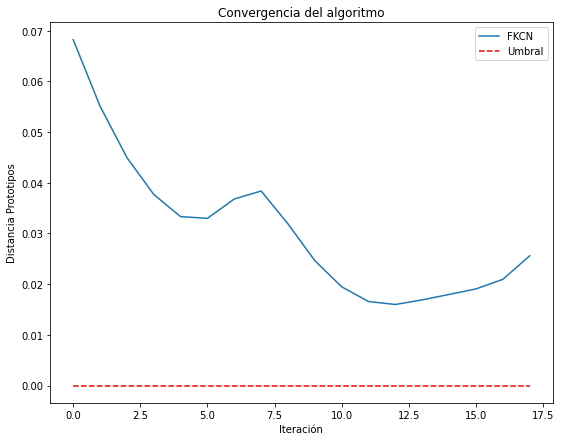

In [66]:
# Graficar historico error
line_epsilon = np.array([epsilon for i in range(len(e_historico))])
fig_1 = plt.figure(figsize=(9,7))
ax = fig_1.add_subplot(1, 1, 1)
inicio_grafico = int(len(e_historico) * 0.1)
ax.plot(e_historico[inicio_grafico:], label='FKCN')
ax.plot(line_epsilon[inicio_grafico:], 'r--', label ='Umbral')
ax.set_ylabel('Distancia Prototipos')
ax.set_xlabel('Iteración')
ax.set_title('Convergencia del algoritmo')
ax.legend()
plt.savefig('historico_error_algoritmo.png')
plt.show()

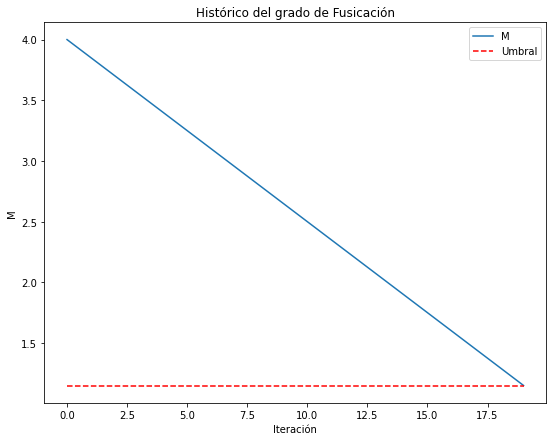

In [67]:
# Graficar historico m
line_epsilon = np.array([m_historico[-1] for i in range(len(m_historico))])
fig_2 = plt.figure(figsize=(9,7))
ax = fig_2.add_subplot(1, 1, 1)
inicio_grafico = int(len(m_historico) * 0.1)
ax.plot(m_historico, label='M')
ax.plot(line_epsilon, 'r--', label ='Umbral')
ax.set_ylabel('M')
ax.set_xlabel('Iteración')
ax.set_title('Histórico del grado de Fusicación')
ax.legend()
plt.savefig('historico_fusicacion_algoritmo.png')
plt.show()

In [68]:
# Hallar los grupos de las observaciones
def asignar_grupos(data,V):
  c = V.shape[0]
  n_fil = len(data) # Número de observaciones
  grupo = []
  distancias = np.zeros((n_fil, c))
  for i in range(n_fil):
    menor = np.Inf
    indice = -1
    for j in range(c):
      distancia = LA.norm(np.subtract(data.iloc[i],V[j]),2)
      distancias[i,j] = distancia
      if distancia < menor:
        #print ('Cambia a ',indice,' por ',j)
        menor = distancia
        indice = j
    grupo.append(indice)
  return grupo
# Almacenar archivo CSV
#datos_originales.to_csv('datos_originales_grupo.csv',encoding='utf-8')

In [69]:
grupo = asignar_grupos(datos,V)

In [70]:
# Visuaizar grupo
datos_originales['grupo'] = grupo
print (datos_originales['grupo'])
# Almacenar
nombre_archivo = 'iris_grupos.csv'
datos_originales.to_csv(nombre_archivo, encoding='utf-8')

0      1
1      1
2      1
3      1
4      1
      ..
145    0
146    4
147    0
148    0
149    4
Name: grupo, Length: 150, dtype: int64


In [71]:
# Calculo de la silueta
promedio_silueta = silhouette_score(datos, grupo, metric='euclidean')
print ('Para k=',c,' grupos')
print ('Promedio Silueta: ', promedio_silueta)

Para k= 6  grupos
Promedio Silueta:  0.351537638774945


In [72]:
def silhouette_plot(X, y, n_clusters, ax=None):

    if ax is None:
        ax = plt.gca()

    # Compute the silhouette scores for each sample
    silhouette_avg = silhouette_score(X, y, metric='euclidean')
    sample_silhouette_values = silhouette_samples(X, y, metric='euclidean')

    y_lower = padding = 2
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        ith_cluster_silhouette_values = []#sample_silhouette_values[y == i]
        for j in range(len(y)):
          if y[j] == i:
            ith_cluster_silhouette_values.append(sample_silhouette_values[j])
        #print ('a')
        #print (ith_cluster_silhouette_values)
        ith_cluster_silhouette_values.sort()

        #print (ith_cluster_silhouette_values)
        print ('cluster: ',i)
        print (len(ith_cluster_silhouette_values))

        size_cluster_i = len(ith_cluster_silhouette_values)
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0,
                         ith_cluster_silhouette_values,
                         facecolor=color,
                         edgecolor=color,
                         alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i + 1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + padding

    ax.set_xlabel("Coeficientes de silueta")
    ax.set_ylabel("Etiqueta Grupo")

    # The vertical line for average silhoutte score of all the values
    ax.axvline(x=silhouette_avg, c='r', alpha=0.8, lw=0.8, ls='-')
    ax.annotate('promedio',
                xytext=(silhouette_avg, y_lower * 1.025),
                xy=(0, 0),
                ha='center',
                alpha=0.8,
                c='r')

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_ylim(0, y_upper + 1)
    ax.set_xlim(-0.075, 1.0)
    return ax

cluster:  0
20
cluster:  1
50
cluster:  2
14
cluster:  3
18
cluster:  4
26
cluster:  5
22


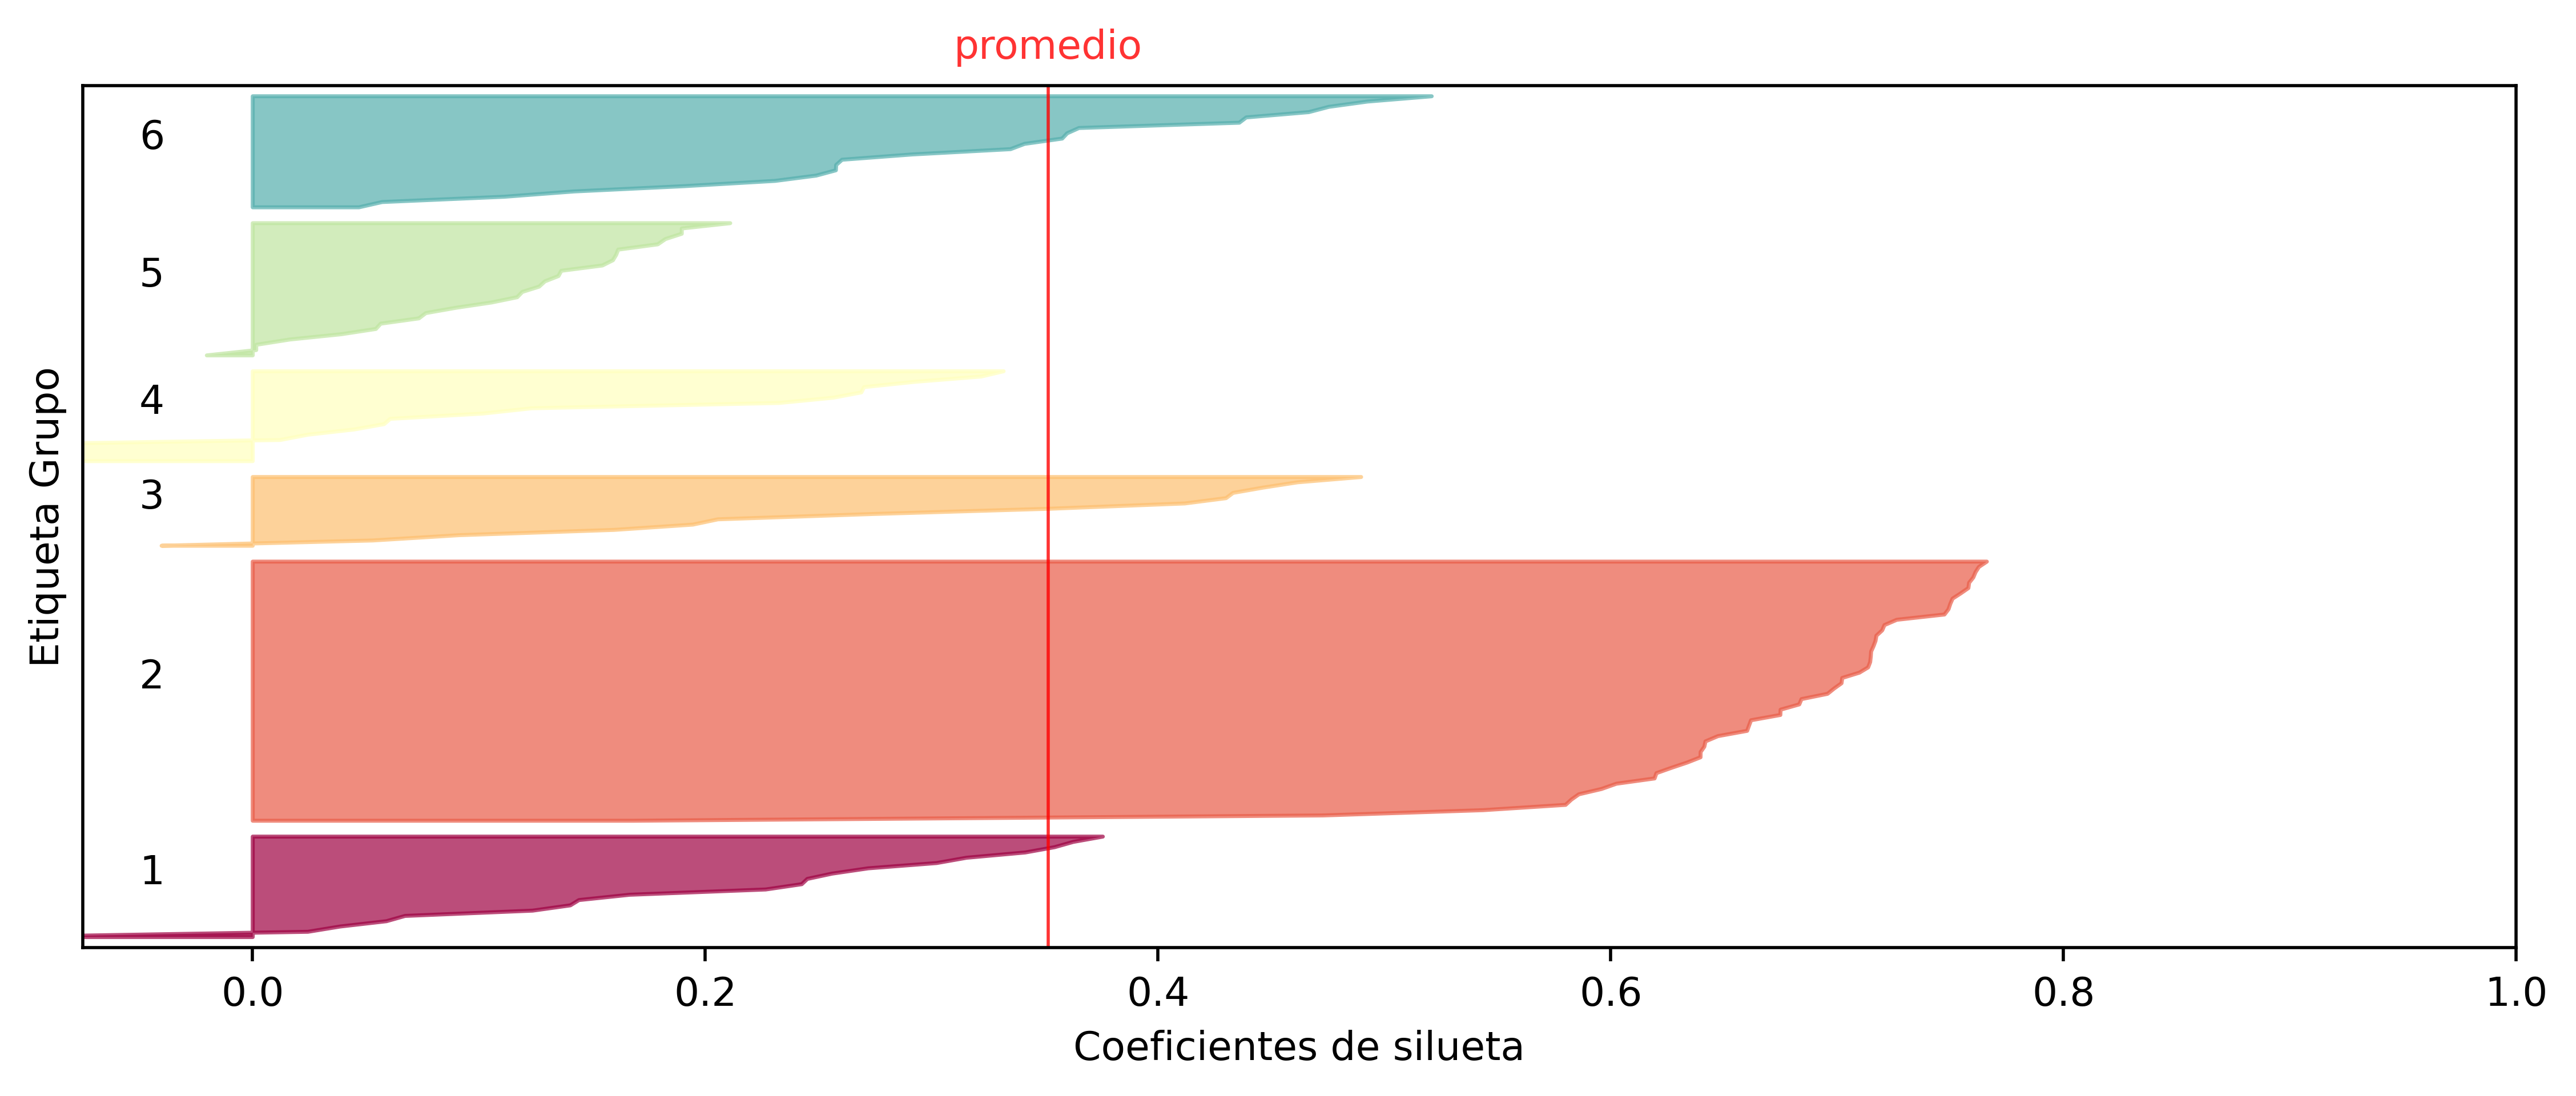

In [73]:
silueta_observaciones = silhouette_samples(datos, grupo, metric='euclidean')

#print (silueta_observaciones)

# Graficar la silueta
fig, ax1 = plt.subplots(1, 1, figsize=(11,4), dpi=500)
ax1 = silhouette_plot(datos, grupo, n_clusters=c, ax=ax1)


In [74]:
# Materialidad
materialidad = np.zeros((2,c))
for i in range(c):
  materialidad[0,i] = grupo.count(i)
  materialidad[1,i] = materialidad[0,i] / len(grupo)

print (materialidad)
#materialidad['nombres'] = ['miembros','porcentaje']
df_materialidad = pd.DataFrame(data=materialidad)
df_materialidad.to_csv('materialidad.csv', encoding='utf-8')

[[20.         50.         14.         18.         26.         22.        ]
 [ 0.13333333  0.33333333  0.09333333  0.12        0.17333333  0.14666667]]
